# Initial Executable Notebook for COG260 Project

Data source: https://osf.io/hjvm5/

Paper: https://psyarxiv.com/efs4p/

Import relevant Python libraries.

In [19]:
from scipy.stats import ks_2samp, mannwhitneyu, ttest_ind,  pearsonr, chi2_contingency, spearmanr

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# the library below is useful for estimating the progress of a for loop
# the use of tqdm will be displayed in Demo 2
from tqdm import tqdm
from itertools import product
from mpl_toolkits.mplot3d import Axes3D

pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv("df_all_raw.csv")
df.columns = list(map(str.lower, df.columns))
df = df.drop(columns=['dataset_id', 'form_id', 'form', 'gloss_in_source', 'iso639p3code', 'mrc_word', 'kucera_francis_frequency'])

C:\Users\akunn\AppData\Local\Temp\ipykernel_19892\3965542381.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_all_raw.csv")


# Data Fields

**clics_form**: the form of the word in the language of interest

**concepticon_id**: unique numerical identifier of underlying concept

**concepticon_gloss**: the concept underlying the word form

**ontological_category**: broad category that the concept falls into

**semantic_field**: a set of words related in meaning

**variety**: the language

**glottocode**: unique alphanumeric identifier for the language variety

**macroarea**: the part of the world the language is common in

**family**: the language family of the current variety

**latitude**: rough latitude where the language variety can be found

**longitude**: rough latitude where the language variety can be found

**age_of_acquisition**: the age at which a concept is typically learned

**concreteness**: a numerical rating of how abstract or concrete a concept is, rated from (100-700)

**familiarity**: a numerical rating of how familiar a concept is to the average person, rated from (100-700)

**imagability**: a numerical rating of how well an average person can mentally visualize a concept, rated from (100-700)

# Concept categorization

First, we will visualize some of the concepticons that we will categorize as either "abstract" or concrete" in tables.

In [3]:
abstract_cpts = df[df['concreteness'] < 400]
abstract_cpts = abstract_cpts[["concepticon_id", "concepticon_gloss", "concreteness"]].drop_duplicates()
abstract_cpts

,concepticon_id,concepticon_gloss,concreteness
30,1035,GOOD,297.0
570,98,ALL,267.0
651,244,LEFT,341.0
786,1203,LONG,381.0
905,1198,MANY,276.0
...,...,...,...
1303158,240,ELECTION,343.0
1304727,1478,WITHOUT,267.0
1307706,1557,BEGINNING,318.0
1355363,2033,DELIVER,393.0


In [4]:
num_abstract = abstract_cpts['concepticon_id'].nunique()
print(f"Number of unique abstract concepts: {num_abstract}")

Number of unique abstract concepts: 356


In [5]:
concrete_cpts = df[df['concreteness'] >= 400]
concrete_cpts = concrete_cpts[["concepticon_id", "concepticon_gloss", "concreteness"]].drop_duplicates()
concrete_cpts

,concepticon_id,concepticon_gloss,concreteness
0,1369,GOLD,576.0
60,1425,GREEN,460.0
122,1481,HAMMER,605.0
152,1277,HAND,604.0
182,1256,HEAD,603.0
...,...,...,...
1305965,287,CONE,573.0
1351537,1015,SOIL,581.0
1351716,637,MOSS,575.0
1352029,2290,PUDDLE,604.0


In [6]:
num_concrete = concrete_cpts['concepticon_id'].nunique()
print(f"Number of unique abstract concepts: {num_concrete}")

Number of unique abstract concepts: 846


To simplify the process of analysis later, we will create a dictionary that maps concepticon_id to a boolean representing whether or not the concepticon is abstract

In [7]:
filtered_df = df[["concepticon_id", "concreteness"]].dropna().drop_duplicates()
id_to_concreteness = filtered_df.set_index("concepticon_id")["concreteness"].to_dict()

### Frequency Histogram for Concreteness of Concepts

To visualise how concreteness is distributed across concepts in the data, we have a histogram:

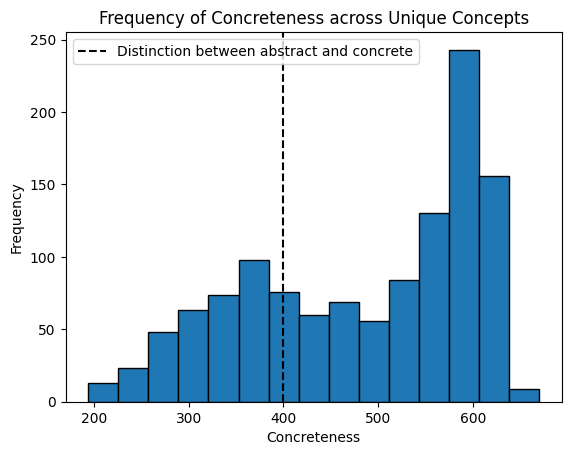

In [8]:
concreteness = filtered_df[["concreteness"]]
plt.hist(concreteness, bins=15,edgecolor="black")
plt.title("Frequency of Concreteness across Unique Concepts")
plt.xlabel("Concreteness")
plt.ylabel("Frequency")
plt.axvline(x=400, ls="--", c="black", label="Distinction between abstract and concrete")
plt.legend()

# Helper functions

For now, these just include the helper + main functions from the demo notebook, copied here for later use:

In [9]:
def per_lang_colexification(curr_df):
    freq_dict = {}
    conc_combo_dict = {}
    type_count_dict = {"abs_abs": 0, "conc_abs": 0, "conc_conc": 0, "all": 0}
    # We iterate through each row, which has the concepts associated with a specific word
    for i, row in curr_df.iterrows():
        # Get the current set of concepts
        a = row['concepticon_id']
        # Create all possible unique combinations of concepts, where each pair is alphabetically sorted
        combos = list(set(map(lambda x: tuple(sorted(x)), product(a, a))))
        # Ensure the concepts in the pair are not identical
        combos = [combo for combo in combos if combo[0] != combo[1]]
        # Add counts for a pair of combinations being colexified
        for combo in combos:            
            # add to concreteness_comb_dict and type_count_dict
            if combo not in conc_combo_dict:
                if combo[0] in id_to_concreteness and combo[1] in id_to_concreteness:
                    conc1 = id_to_concreteness[combo[0]]
                    conc2 = id_to_concreteness[combo[1]]
                    
                    conc_combo_dict[combo] = (conc1, conc2)
                    
                    type_count_dict["all"] += 1
                    if conc1 > 400 and conc2 > 400:
                        type_count_dict["conc_conc"] += 1
                    elif conc1 <= 400 and conc2 <= 400:
                        type_count_dict["abs_abs"] += 1
                    else:
                        type_count_dict["conc_abs"] += 1
                    
            # add to freq dict (if it was added to concreteness)
            if combo in freq_dict:
                freq_dict[combo] += 1
            else:
                freq_dict[combo] = 1

    # Create a DataFrame out of our dictionary and return the colexification counts for two concepts
    tmp1 = pd.DataFrame(list(conc_combo_dict.items()), columns=['colex_pair', 'concreteness'])
    tmp2 = pd.DataFrame(list(freq_dict.items()), columns=['colex_pair', 'frequency'])
    per_lang = pd.merge(tmp1, tmp2, on='colex_pair', how='inner')
    
    # create dataframe to store percentages of types
    type_counts = pd.DataFrame([type_count_dict])
    
    return per_lang, type_counts

In [10]:
def main():
    all_pairs_dfs = []
    all_type_counts_dfs = []
    for variety in tqdm(df['variety'].unique()):
        sub = df[df['variety'] == variety]
        agg = sub.groupby("clics_form")[['concepticon_gloss', 'concepticon_id']].agg(list)
        agg['num_concepts'] = agg['concepticon_gloss'].apply(lambda x: len(set(x)))
        colex = agg[agg['num_concepts']>1]
        colex['concepticon_gloss'] = colex['concepticon_gloss'].apply(lambda x: sorted(list(set(x))))
        # We skip any language where no concepts are colexified
        if colex.shape[0] == 0:
            continue
        curr_df, curr_type_count = per_lang_colexification(colex)
        all_pairs_dfs.append(curr_df)
        all_type_counts_dfs.append(curr_type_count)
    mega = pd.concat(all_pairs_dfs)
    mega = mega.groupby(["colex_pair", "concreteness"]).sum().reset_index()
    
    all_counts = pd.concat(all_type_counts_dfs)
    
    return mega, all_counts

In [11]:
mega, counts = main()
mega['x'] = mega['concreteness'].apply(lambda coord: coord[0])
mega['y'] = mega['concreteness'].apply(lambda coord: coord[1])

100%|██████████| 3050/3050 [04:52<00:00, 10.42it/s]


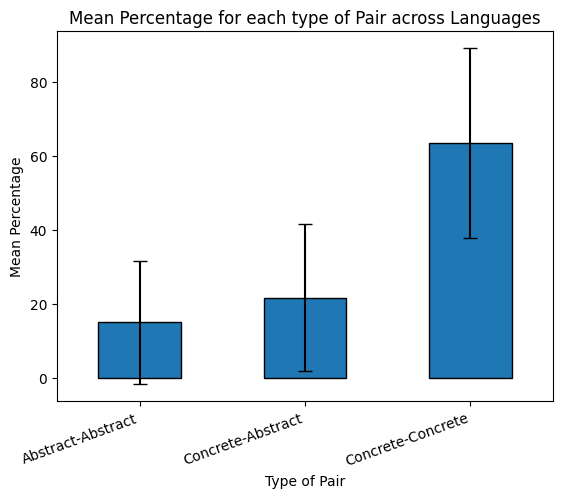

In [12]:
counts = counts[counts["all"] != 0]
type_percents = pd.DataFrame({
    'Abstract-Abstract': counts['abs_abs'] / counts['all'] * 100,
    'Concrete-Abstract': counts['conc_abs'] / counts['all'] * 100,
    'Concrete-Concrete': counts['conc_conc'] / counts['all'] * 100
})
means = type_percents.mean()
std_devs = type_percents.std()
# Plot the bar graph with error bars
fig, ax = plt.subplots()

means.plot(kind='bar', yerr=std_devs, ax=ax, capsize=5, edgecolor='black')

# Set labels and title
ax.set_ylabel('Mean Percentage')
ax.set_xlabel('Type of Pair')
ax.set_title('Mean Percentage for each type of Pair across Languages')
plt.xticks(rotation=20, ha="right")

# Show the plot
plt.show()

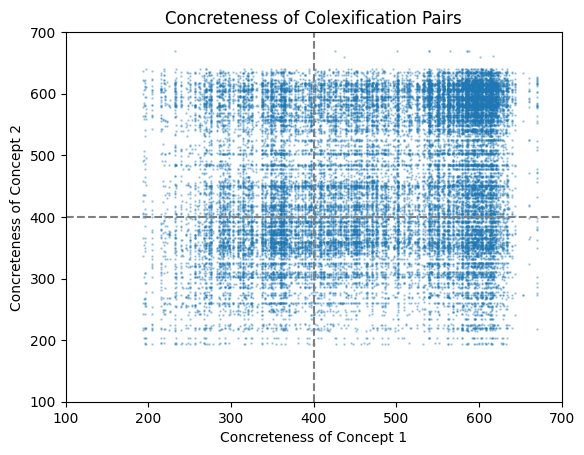

In [13]:
plt.figure()
plt.scatter(mega['x'], mega['y'], s=0.7, alpha=0.3)
plt.xlim(100, 700)
plt.ylim(100, 700)
plt.xlabel('Concreteness of Concept 1')
plt.ylabel('Concreteness of Concept 2')
plt.title('Concreteness of Colexification Pairs')
plt.axvline(x=400, ls="--", c="gray")
plt.axhline(y=400, ls="--", c="gray")
plt.show()

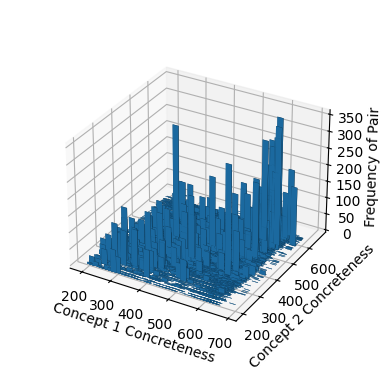

<Figure size 640x480 with 0 Axes>

In [14]:
# Create a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D histogram
ax.bar3d(mega['x'], mega['y'], 0, 20, 1, mega['frequency'], shade=True)

# Set labels for axes
ax.set_xlabel('Concept 1 Concreteness')
ax.set_ylabel('Concept 2 Concreteness')
ax.set_zlabel('Frequency of Pair')
ax.set_box_aspect(aspect = None, zoom=0.8)
ax = plt.figure(constrained_layout=True)
# Show the plot
plt.show()

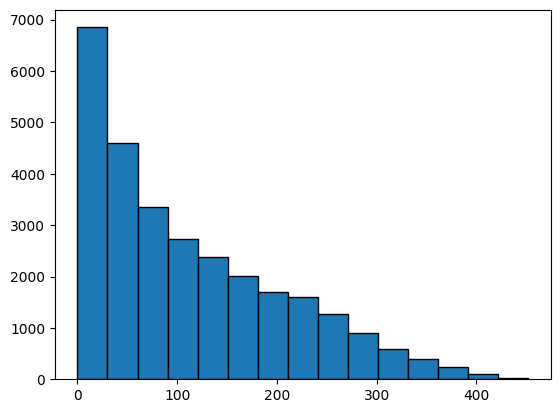

In [15]:
mega["absolute_diff"] = abs(mega["x"] - mega["y"])
plt.figure()
plt.hist(mega["absolute_diff"], bins=15, edgecolor="black")
plt.show()

In [17]:
# Testing for Significance Between Our Abstract and Concrete Concepts Given Our Cut-Off of 400 Using a T-Test

# Assuming you have two pandas Series or NumPy arrays
group1 = abstract_cpts['concreteness']
group2 = concrete_cpts['concreteness']


# Perform Welch's t-test
t_stat, p_value = ttest_ind(group1, group2, equal_var=False)

# Since the p value is low we can continue knowing that there is a significant difference in concreteness between the two categories given our working definition.
print(f"t-statistic is: {t_stat} ", f"p-value is: {p_value}")

# TODO: maybe email Jai and ask if a chi-squared test is more appropriate

t-statistic is: -65.11352444147569  p-value is: 0.0


In [20]:
# Testing for Linear Realtionship Between Our Abstract and Concrete Colexification Using a Pearson Correlation Like in Class

# Assuming you have two pandas Series or NumPy arrays
x = mega['x']
y = mega['y']
correlation_coefficient, correlation_p_value = pearsonr(x, y)

print(f"Correlation Coefficient is: {correlation_coefficient} ", 
      f"Correlation P- Value is: {correlation_p_value}")

# It makes sense that the relationship is non-linear
# TODO: research a test that could show non linear co-variance, it will likely need to be at least 2nd order
# The p-value is also pretty high

Correlation Coefficient is: 0.2123687917903988  Correlation P- Value is: 1.3070326362826237e-290


In [ ]:
# More Testing, Likely do Multivariate Analysis

# TODO: the frequency test Professor Xu mentioned in class
# TODO: look at your notes from that class and see if an ANOVA or MANOVA is applicable
# TODO: cluster analysis like in the lab
# TODO: see if you can do factor analysis for this (highly likely you can)
    # if so, try and generate a vizualization of it